# ASL Alphabet Classifier Test #1

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will be overfitted, however it's a good test of the library.
<br>
<br>
<br>

In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import fastai

# plt.style.use('dark')


In [2]:
path = '../data/external/Training Set'

<br>

### Create the DataBlock

In [3]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

# learn_inf = load_learner('../models/export-resnet101-tune10un-tune2ft.pkl')



<br>

## Resize and add basic image augmentation

In [4]:
# signs = signs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
signs = signs.new(item_tfms=Resize(300, method=ResizeMethod.Squish))

# signs.apply_tfms(Image.flip)


<br>

### Load the data by path

In [5]:
dls = signs.dataloaders(path)


<br>

### Verify the Training and Validation Batches

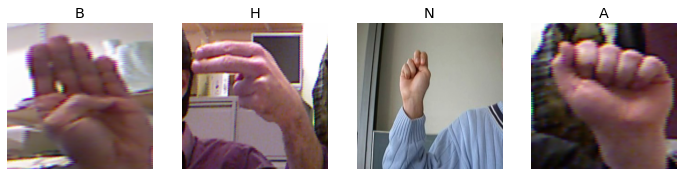

In [6]:
dls.train.show_batch(max_n=4, nrows=1)

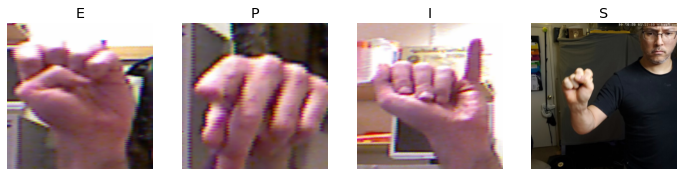

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

<br>

### Define the model (Resnet34) and fit

In [8]:
learn = cnn_learner(dls, resnet34 , metrics=error_rate)

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

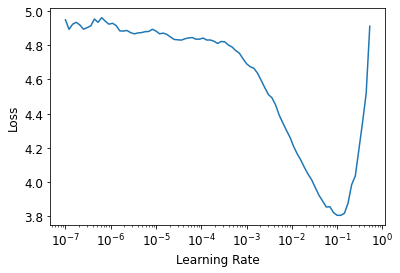

In [9]:
lr_min,lr_steep = learn.lr_find()


In [10]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


<br>
<br>
<br>

## Fit the last layer to our data

In [ ]:
learn.fit_one_cycle(2, 4e-2)

In [11]:
learn.fine_tune(6, freeze_epochs=3, base_lr=2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.906452,0.487840,0.144907,06:47
1,0.327687,0.138073,0.042302,06:44
2,0.156834,0.066275,0.020066,06:48


epoch,train_loss,valid_loss,error_rate,time
0,0.055806,0.032197,0.009636,09:44
1,0.047802,0.048258,0.012601,09:39
2,0.021381,0.016579,0.005136,09:39
3,0.007197,0.008203,0.002012,09:39
4,0.000509,0.003172,0.000741,09:38
5,0.000076,0.002900,0.000688,09:38


<br>
<br>
<br>

## Unfreeze the rest of the layers and find a new learning rate for the whole net.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

<br>
<br>
<br>

## Fit the whole network at an appropriate learning rate

In [ ]:
learn.fit_one_cycle(2, lr_max=5e-5)

In [ ]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

<br>

### Show the top 5 most error prone images

In [1]:
interp.plot_top_losses(15, nrows=3)

NameError: name 'interp' is not defined

<br>

### Clean the images that were hard to interpret and obviously bad

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<br>
<br>
<hr>
<br>
<br>

## Persist the Model

<br>
<br>

In [12]:
learn.export('../models/200923-0100-FALL-ft6f3')
path = Path('../models')
path.ls(file_exts='.pkl')

(#5) [Path('../models/export-resnet101-FALL-tune2ft-tune10un-tune2ft.pkl'),Path('../models/export-resnet101-F-tune2ft-tune10un-tune2ft.pkl'),Path('../models/export-resnet101-tune10un-tune2ft.pkl'),Path('../models/200921-0235-RN101-ALL-ut10-f2ft-F-f2ft.pkl'),Path('../models/200921-0121-export-resnet101-FALL-tune2ft-tune6un-tune2ft.pkl')]

In [ ]:
%cd ..
learn_inf.save('save/200921-0201-export-resnet101-FALL-tune2ft-tune6un-tune2ft-F-t2ft-ut3-t2ft-t2ft')
%cd notebooks

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

<br>
<br>

## Make a Notebook App

<br>

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
# with out_pl: display(img.to_thumb(200,200))
# out_pl

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(200,200))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select an image: '),
    btn_upload, btn_run, out_pl, lbl_pred])